## Import The Dataset

In [1]:
import numpy as np
import time
import copy
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

## Data Preprocessing

In [2]:
transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}
data_size = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

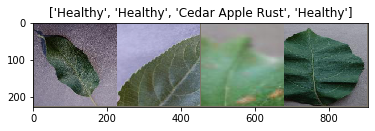

In [12]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

## Create a function to train and to evaluate the model

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / data_size[phase]
            epoch_acc = running_corrects.double() / data_size[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

## Declare and Download (optional) the pretrained model

In [4]:
model_resnet = models.resnet18(pretrained=True)

In [3]:
model_vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Irfan Alghani Khalid/.cache\torch\checkpoints\vgg16-397923af.pth


In [4]:
model_inceptionv3 = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to C:\Users\Irfan Alghani Khalid/.cache\torch\checkpoints\inception_v3_google-1a9a5a14.pth


In [5]:
model_alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to C:\Users\Irfan Alghani Khalid/.cache\torch\checkpoints\alexnet-owt-4df8aa71.pth


# Set the model, parameters to tune, criterion, oprimizer, and the weight update

### VGG-16 Architecture

In [41]:
for param in model_vgg16.parameters():
    param.requires_grad = False

num_ftrs = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model_vgg16 = model_vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_vgg16.classifier[6].parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [44]:
model_vgg16 = train_model(model_vgg16, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5082 Acc: 0.8164
val Loss: 0.2406 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4444 Acc: 0.8444
val Loss: 0.1936 Acc: 0.9490

Epoch 2/24
----------
train Loss: 0.4170 Acc: 0.8576
val Loss: 0.1470 Acc: 0.9529

Epoch 3/24
----------
train Loss: 0.4029 Acc: 0.8637
val Loss: 0.1736 Acc: 0.9333

Epoch 4/24
----------
train Loss: 0.3557 Acc: 0.8852
val Loss: 0.1350 Acc: 0.9529

Epoch 5/24
----------
train Loss: 0.4106 Acc: 0.8681
val Loss: 0.1764 Acc: 0.9333

Epoch 6/24
----------
train Loss: 0.4169 Acc: 0.8637
val Loss: 0.1326 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.3500 Acc: 0.8926
val Loss: 0.1248 Acc: 0.9647

Epoch 8/24
----------
train Loss: 0.3416 Acc: 0.8887
val Loss: 0.1123 Acc: 0.9529

Epoch 9/24
----------
train Loss: 0.3084 Acc: 0.8913
val Loss: 0.1182 Acc: 0.9529

Epoch 10/24
----------
train Loss: 0.2984 Acc: 0.9040
val Loss: 0.1153 Acc: 0.9647

Epoch 11/24
----------
train Loss: 0.3051 Acc: 0.8931
val Loss: 0.1204 Acc: 0.9647

Ep

### ResNet Architecture

In [49]:
for param in model_resnet.parameters():
    param.requires_grad = False

num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, len(class_names))
model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [50]:
model_resnet = train_model(model_resnet, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7583 Acc: 0.7077
val Loss: 0.2599 Acc: 0.9255

Epoch 1/24
----------
train Loss: 0.5358 Acc: 0.8103
val Loss: 0.1720 Acc: 0.9333

Epoch 2/24
----------
train Loss: 0.5212 Acc: 0.8098
val Loss: 0.1459 Acc: 0.9529

Epoch 3/24
----------
train Loss: 0.4364 Acc: 0.8418
val Loss: 0.1577 Acc: 0.9451

Epoch 4/24
----------
train Loss: 0.4518 Acc: 0.8344
val Loss: 0.1248 Acc: 0.9529

Epoch 5/24
----------
train Loss: 0.4502 Acc: 0.8383
val Loss: 0.1211 Acc: 0.9569

Epoch 6/24
----------
train Loss: 0.4754 Acc: 0.8335
val Loss: 0.1378 Acc: 0.9490

Epoch 7/24
----------
train Loss: 0.3959 Acc: 0.8554
val Loss: 0.1172 Acc: 0.9647

Epoch 8/24
----------
train Loss: 0.3609 Acc: 0.8690
val Loss: 0.1277 Acc: 0.9569

Epoch 9/24
----------
train Loss: 0.3653 Acc: 0.8751
val Loss: 0.1263 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.3580 Acc: 0.8681
val Loss: 0.1059 Acc: 0.9647

Epoch 11/24
----------
train Loss: 0.3863 Acc: 0.8580
val Loss: 0.1313 Acc: 0.9608

Ep

In [5]:
for param in model_resnet.parameters():
    param.requires_grad = False

num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, len(class_names))
model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [6]:
model_resnet = train_model(model_resnet, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7221 Acc: 0.7182
val Loss: 0.2825 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.4867 Acc: 0.8098
val Loss: 0.1549 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4826 Acc: 0.8164
val Loss: 0.1943 Acc: 0.9255

Epoch 3/24
----------
train Loss: 0.5605 Acc: 0.8138
val Loss: 0.1159 Acc: 0.9569

Epoch 4/24
----------
train Loss: 0.4739 Acc: 0.8392
val Loss: 0.1291 Acc: 0.9529

Epoch 5/24
----------
train Loss: 0.5175 Acc: 0.8155
val Loss: 0.1160 Acc: 0.9569

Epoch 6/24
----------
train Loss: 0.5044 Acc: 0.8234
val Loss: 0.1401 Acc: 0.9451

Epoch 7/24
----------
train Loss: 0.3871 Acc: 0.8650
val Loss: 0.1084 Acc: 0.9647

Epoch 8/24
----------
train Loss: 0.3434 Acc: 0.8747
val Loss: 0.1257 Acc: 0.9569

Epoch 9/24
----------
train Loss: 0.3556 Acc: 0.8760
val Loss: 0.1021 Acc: 0.9686

Epoch 10/24
----------
train Loss: 0.3879 Acc: 0.8585
val Loss: 0.1121 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.3576 Acc: 0.8699
val Loss: 0.1359 Acc: 0.9529

Ep

In [9]:
model_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### AlexNet Architecture

In [61]:
for param in model_alexnet.parameters():
    param.requires_grad = False

num_ftrs = model_alexnet.classifier[6].in_features
model_alexnet.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model_alexnet = model_alexnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_alexnet.classifier[6].parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [62]:
model_alexnet = train_model(model_alexnet, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8808 Acc: 0.8067
val Loss: 0.4606 Acc: 0.8941

Epoch 1/24
----------
train Loss: 0.6680 Acc: 0.8703
val Loss: 0.2884 Acc: 0.9333

Epoch 2/24
----------
train Loss: 0.7559 Acc: 0.8615
val Loss: 0.3503 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.6549 Acc: 0.8786
val Loss: 0.2968 Acc: 0.9294

Epoch 4/24
----------
train Loss: 0.6638 Acc: 0.8817
val Loss: 0.3350 Acc: 0.9373

Epoch 5/24
----------
train Loss: 0.6190 Acc: 0.8940
val Loss: 0.2408 Acc: 0.9608

Epoch 6/24
----------
train Loss: 0.5249 Acc: 0.8988
val Loss: 0.2852 Acc: 0.9333

Epoch 7/24
----------
train Loss: 0.3991 Acc: 0.9172
val Loss: 0.1568 Acc: 0.9490

Epoch 8/24
----------
train Loss: 0.3714 Acc: 0.9154
val Loss: 0.1745 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.3343 Acc: 0.9264
val Loss: 0.1197 Acc: 0.9686

Epoch 10/24
----------
train Loss: 0.3455 Acc: 0.9172
val Loss: 0.1365 Acc: 0.9686

Epoch 11/24
----------
train Loss: 0.3270 Acc: 0.9238
val Loss: 0.0892 Acc: 0.9765

Ep

In [63]:
model_alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Test the model

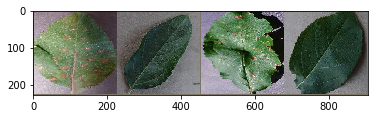

GroundTruth:  Cedar Apple Rust, Healthy, Black Rot, Healthy
Predicted:  Cedar Apple Rust, Healthy, Black Rot, Healthy


In [13]:
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ', '.join('%5s' % class_names[x] for x in labels))
images = images.to(device)
labels = images.to(device)
output = model_resnet(images)
_, predicted = torch.max(output, 1)
print('Predicted: ', ', '.join('%5s' % class_names[x] for x in predicted))

### Save the model

In [67]:
# Save The Model
PATH = './fix_resnet18.pth'
torch.save(model_resnet.state_dict(), PATH)